In [1]:
print("hello")

hello


In [7]:
import os
import scanpy as sc
import pandas as pd
from scipy.io import mmread
import anndata as ad
from scipy.sparse import csr_matrix
import numpy as np
import glob
import gc
import traceback

In [21]:
base_dir = "aaa/bbb/bustools"  # Обновленный путь к данным
output_file = "combined_data.h5ad"

def load_dataset(mtx_path, barcodes_path, genes_path):
    """Загрузка датасета из отдельных файлов с оптимизацией памяти"""
    try:
        # Загрузка метаданных
        barcodes = pd.read_csv(barcodes_path, sep='\t', header=None, dtype='str')[0].values
        genes = pd.read_csv(genes_path, sep='\t', header=None, dtype='str')[0].values
        mtx = mmread(mtx_path).astype(np.int32)
        
        # Создание AnnData с правильной ориентацией
        if mtx.shape[0] == len(barcodes):
            adata = ad.AnnData(
                X=csr_matrix(mtx, dtype=np.int32),
                obs=pd.DataFrame(index=barcodes),
                var=pd.DataFrame(index=genes)
            )
        else:
            adata = ad.AnnData(
                X=csr_matrix(mtx.T, dtype=np.int32),
                obs=pd.DataFrame(index=barcodes),
                var=pd.DataFrame(index=genes)
            )
        return adata
    except Exception as e:
        print(f"Ошибка загрузки данных из {mtx_path}:")
        traceback.print_exc()
        return None

def combine_datasets(base_path):
    print(f"Начало обработки папки: {base_path}")
    print(f"Содержимое папки: {os.listdir(base_path)}")
    
    adatas = []
    # Поиск всех файлов матриц
    matrix_files = glob.glob(os.path.join(base_path, "*.mtx"))
    
    print(f"Найдено файлов матриц: {len(matrix_files)}")
    
    for matrix_file in matrix_files:
        try:
            # Извлечение базового имени файла (без расширения)
            base_name = os.path.basename(matrix_file).split('.')[0]
            sample_id = base_name
            
            # Определение путей к файлам баркодов и генов
            # Ищем файлы с тем же базовым именем и соответствующими суффиксами
            barcodes_files = glob.glob(os.path.join(base_path, f"{base_name}*.barcodes.txt"))
            genes_files = glob.glob(os.path.join(base_path, f"{base_name}*.genes.txt"))
            
            # Если не найдено, пробуем альтернативные варианты имен
            if not barcodes_files:
                barcodes_files = glob.glob(os.path.join(base_path, f"{base_name}*barcodes*"))
            if not genes_files:
                genes_files = glob.glob(os.path.join(base_path, f"{base_name}*genes*"))
            
            # Выбираем первый подходящий файл
            barcodes_file = barcodes_files[0] if barcodes_files else None
            genes_file = genes_files[0] if genes_files else None
            
            print(f"\nОбработка образца: {sample_id}")
            print(f"Файл матрицы: {matrix_file}")
            print(f"Найденные barcodes файлы: {barcodes_files}")
            print(f"Найденные genes файлы: {genes_files}")
            print(f"Используемые barcodes: {barcodes_file}")
            print(f"Используемые genes: {genes_file}")
            
            if not barcodes_file or not genes_file:
                missing = []
                if not barcodes_file: missing.append("barcodes")
                if not genes_file: missing.append("genes")
                print(f"Пропускаем {sample_id}: отсутствуют файлы ({', '.join(missing)})")
                continue
                
            # Загрузка данных
            adata = load_dataset(matrix_file, barcodes_file, genes_file)
            if adata is None:
                continue
                
            # Добавление идентификаторов образца
            adata.obs_names = [f"{sample_id}_{x}" for x in adata.obs_names]
            adata.obs["dataset"] = sample_id
            adata.obs["dataset"] = adata.obs["dataset"].astype('category')
            
            adatas.append(adata)
            print(f"Успешно загружен {sample_id}: {adata.shape[0]} клеток, {adata.shape[1]} генов")
            
            del adata
            gc.collect()
            
        except Exception as e:
            print(f"Критическая ошибка обработки {matrix_file}:")
            traceback.print_exc()
            continue

    if not adatas:
        raise ValueError("Не найдено валидных датасетов для объединения")
    
    # Поэтапное объединение
    print("\nНачало объединения датасетов...")
    combined = adatas[0]
    for i, adata in enumerate(adatas[1:]):
        print(f"Объединение датасета {i+2}/{len(adatas)}...")
        combined = ad.concat(
            [combined, adata],
            axis=0,
            join="outer",
            fill_value=0,
            merge="unique"
        )
        gc.collect()

    combined.var_names_make_unique()
    return combined

# Запуск обработки с обработкой исключений
try:
    combined_adata = combine_datasets(base_dir)
    combined_adata.write(output_file)
    print(f"\nУспешно объединено: {combined_adata.shape[0]} клеток, {combined_adata.shape[1]} генов")
    print(f"Результат сохранен в: {output_file}")
except Exception as e:
    print(f"\nОшибка в основном процессе: {str(e)}")
    traceback.print_exc()

Начало обработки папки: aaa/bbb/bustools
Содержимое папки: ['ERR11685720.mtx', 'ERR11685722.mtx', 'ERR11685721.mtx', 'ERR11685725.mtx', 'ERR11685719.mtx', 'ERR11685724.mtx', 'ERR11685723.mtx', 'ERR7783779.mtx', 'ERR11685726.mtx', 'ERR7783783.mtx', 'ERR7783787.mtx', 'ERR7783781.mtx', 'ERR7783785.mtx', 'ERR7783791.mtx', 'ERR7783793.mtx', 'SRR9020425.mtx', 'ERR7783789.mtx', 'SRR9020427.mtx', 'ERR7783782.mtx', 'ERR7783790.mtx', 'ERR7783786.mtx', 'ERR7783780.mtx', 'SRR9020428.mtx', 'ERR7783792.mtx', 'ERR7783794.mtx', 'ERR7783784.mtx', 'SRR9020426.mtx', 'ERR7783788.mtx', 'ERR11685724.genes.txt', 'ERR11685724.barcodes.txt', 'ERR7783783.genes.txt', 'ERR7783783.barcodes.txt', 'ERR7783779.genes.txt', 'ERR7783779.barcodes.txt', 'ERR11685720.genes.txt', 'ERR11685720.barcodes.txt', 'ERR11685726.genes.txt', 'ERR11685726.barcodes.txt', 'ERR7783781.genes.txt', 'ERR7783781.barcodes.txt', 'ERR7783791.genes.txt', 'ERR7783791.barcodes.txt', 'ERR7783793.genes.txt', 'ERR7783793.barcodes.txt', 'ERR11685723.g

Traceback (most recent call last):
  File "/tmp/ipykernel_2783088/3219868142.py", line 8, in load_dataset
    barcodes = pd.read_csv(barcodes_path, sep='\t', header=None, dtype='str')[0].values
  File "/nfs/home/aneurov/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/nfs/home/aneurov/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/nfs/home/aneurov/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/nfs/home/aneurov/.local/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 1898, in _make_engine
    return mapping[engine](f, **self.options)
  File "/nfs/home/aneurov/.local/lib/python3.10/site-packages/pandas/io/parsers/c_parser_wrapper.py", line 93, in __init__
    self._reader = pa

Успешно загружен ERR7783781: 1 клеток, 12122 генов

Обработка образца: ERR7783785
Файл матрицы: aaa/bbb/bustools/ERR7783785.mtx
Найденные barcodes файлы: ['aaa/bbb/bustools/ERR7783785.barcodes.txt']
Найденные genes файлы: ['aaa/bbb/bustools/ERR7783785.genes.txt']
Используемые barcodes: aaa/bbb/bustools/ERR7783785.barcodes.txt
Используемые genes: aaa/bbb/bustools/ERR7783785.genes.txt
Ошибка загрузки данных из aaa/bbb/bustools/ERR7783785.mtx:

Обработка образца: ERR7783791
Файл матрицы: aaa/bbb/bustools/ERR7783791.mtx
Найденные barcodes файлы: ['aaa/bbb/bustools/ERR7783791.barcodes.txt']
Найденные genes файлы: ['aaa/bbb/bustools/ERR7783791.genes.txt']
Используемые barcodes: aaa/bbb/bustools/ERR7783791.barcodes.txt
Используемые genes: aaa/bbb/bustools/ERR7783791.genes.txt
Ошибка загрузки данных из aaa/bbb/bustools/ERR7783791.mtx:

Обработка образца: ERR7783793
Файл матрицы: aaa/bbb/bustools/ERR7783793.mtx
Найденные barcodes файлы: ['aaa/bbb/bustools/ERR7783793.barcodes.txt']
Найденные gen

In [3]:
current_directory = os.getcwd()
print("Текущая директория:", current_directory)

Текущая директория: /mnt/tank/scratch/aneurov/aaa


In [4]:
new_directory = '/mnt/tank/scratch/aneurov'
os.chdir(new_directory)

# Проверить, что директория изменилась
print("Новая директория:", os.getcwd())

Новая директория: /mnt/tank/scratch/aneurov


In [5]:
# Загрузка объединенных данных
adata = sc.read("adata_with_lowres_clusters.h5ad")
adata


AnnData object with n_obs × n_vars = 756127 × 3000
    obs: 'dataset', 'n_genes', 'leiden', 'ERR123123', 'ERR7793780', 'selected_samples', 'dataset_group', 'highlight', 'leiden_lowres'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'ERR123123_colors', 'ERR7793780_colors', 'dataset_colors', 'dataset_group_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lowres', 'leiden_lowres_colors', 'log1p', 'neighbors', 'pca', 'selected_samples_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
# Фильтрация низкокачественных клеток
sc.pp.filter_cells(adata, min_genes=12)  # Минимум 200 генов на клетку
sc.pp.filter_genes(adata, min_cells=10)   # Ген должен встречаться минимум в 10 клетках

In [10]:
adata

AnnData object with n_obs × n_vars = 756127 × 10994
    obs: 'dataset', 'n_genes'
    var: 'n_cells'

In [30]:
# Удаление клеток с нулевыми счетами
cell_counts = np.array(adata.X.sum(axis=1)).flatten()
adata = adata[cell_counts > 0, :]
print(f"После удаления нулевых клеток: {adata.n_obs} клеток")

После удаления нулевых клеток: 6001 клеток


In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [12]:
try:
    # Попробуем более легкий метод
    sc.pp.highly_variable_genes(
        adata,
        n_top_genes=3000,  # Фиксированное значение для стабильности
        flavor='seurat',   # Менее требовательный к памяти
        span=0.3
    )
    print(f"Успешно: отобрано {sum(adata.var.highly_variable)} генов (метод Seurat)")

except Exception as e:
    print(f"Ошибка Seurat: {e}")
    print("Используем ручной расчет дисперсии...")
    
    # Ручной расчет вариабельности
    if issparse(adata.X):
        # Эффективный расчет для разреженных матриц
        mean = np.array(adata.X.mean(axis=0)).flatten()
        mean_sq = np.array(adata.X.power(2).mean(axis=0)).flatten()
        variances = mean_sq - mean**2
    else:
        variances = np.var(adata.X, axis=0)
    
    # Сохранение результатов
    adata.var['variances'] = variances
    adata.var['highly_variable'] = False
    
    # Выбор топ генов
    n_genes = adata.n_vars
    n_top = min(4000, max(2000, int(n_genes * 0.15)))
    top_genes_idx = np.argsort(variances)[::-1][:n_top]
    
    # Пометить выбранные гены
    adata.var.iloc[top_genes_idx, adata.var.columns.get_loc('highly_variable')] = True
    print(f"Ручной выбор: отобрано {n_top} генов по дисперсии")

# Фильтрация данных
adata = adata[:, adata.var.highly_variable].copy()
print(f"Финальный размер: {adata.n_obs} клеток, {adata.n_vars} генов")

Успешно: отобрано 3000 генов (метод Seurat)
Финальный размер: 756127 клеток, 3000 генов


In [13]:
# 2. PCA с оптимизацией
sc.pp.scale(adata, max_value=10, zero_center=True)

sc.tl.pca(
    adata, 
    n_comps=100,
    svd_solver='randomized',
    random_state=42
)

# Автоматический выбор числа компонент
variance_ratio = np.cumsum(adata.uns['pca']['variance_ratio'])
n_pcs = np.argmax(variance_ratio > 0.85) + 1  # 85% объясненной дисперсии
n_pcs = max(30, min(n_pcs, 50))
print(f"Используется {n_pcs} PC (объяснено {variance_ratio[n_pcs-1]:.2f} дисперсии)")


/usr/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Используется 30 PC (объяснено 0.07 дисперсии)


In [14]:
sc.external.pp.harmony_integrate(adata, 'dataset', theta=2.0)

# 3. Построение графа соседей на основе гармонизированных данных
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, use_rep='X_pca_harmony')

# 4. UMAP на основе гармонизированных данных
sc.tl.umap(adata)

# 5. Кластеризация
sc.tl.leiden(adata, resolution=0.5)

2025-06-17 21:13:23,829 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-17 21:15:09,318 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-17 21:15:15,103 - harmonypy - INFO - Iteration 1 of 10
2025-06-17 21:24:02,410 - harmonypy - INFO - Iteration 2 of 10
2025-06-17 21:28:21,029 - harmonypy - INFO - Iteration 3 of 10
2025-06-17 21:33:10,997 - harmonypy - INFO - Iteration 4 of 10
2025-06-17 21:39:35,290 - harmonypy - INFO - Iteration 5 of 10
2025-06-17 21:44:50,751 - harmonypy - INFO - Iteration 6 of 10
2025-06-17 21:52:23,108 - harmonypy - INFO - Iteration 7 of 10
2025-06-17 22:01:15,243 - harmonypy - INFO - Iteration 8 of 10
2025-06-17 22:07:16,266 - harmonypy - INFO - Converged after 8 iterations
/tmp/ipykernel_2822952/2939737164.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also 

In [18]:
adata.obs['dataset']

ERR11685720_AACCATGAGAAGGCTT    ERR11685720
ERR11685720_AACCATGAGCTGATAG    ERR11685720
ERR11685720_AACCATGCAAGCTGAG    ERR11685720
ERR11685720_AACCATGCAAGTCATC    ERR11685720
ERR11685720_AACCATGCACGGTGTC    ERR11685720
                                   ...     
SRR10693363_TCTTCCTTCCTTTCTT    SRR10693363
SRR10693363_TTCTCTCTCCCTCTCT    SRR10693363
SRR10693363_TTCTTCCTCTTCTTCC    SRR10693363
SRR10693363_TTGCCTGCATACTGTG    SRR10693363
SRR10693363_TTTCCTCTCCCTCTCT    SRR10693363
Name: dataset, Length: 756127, dtype: category
Categories (73, object): ['ERR7783780', 'ERR7783782', 'ERR7783784', 'ERR7783786', ..., 'SRR15990915', 'SRR15990916', 'SRR15990917', 'SRR15990918']

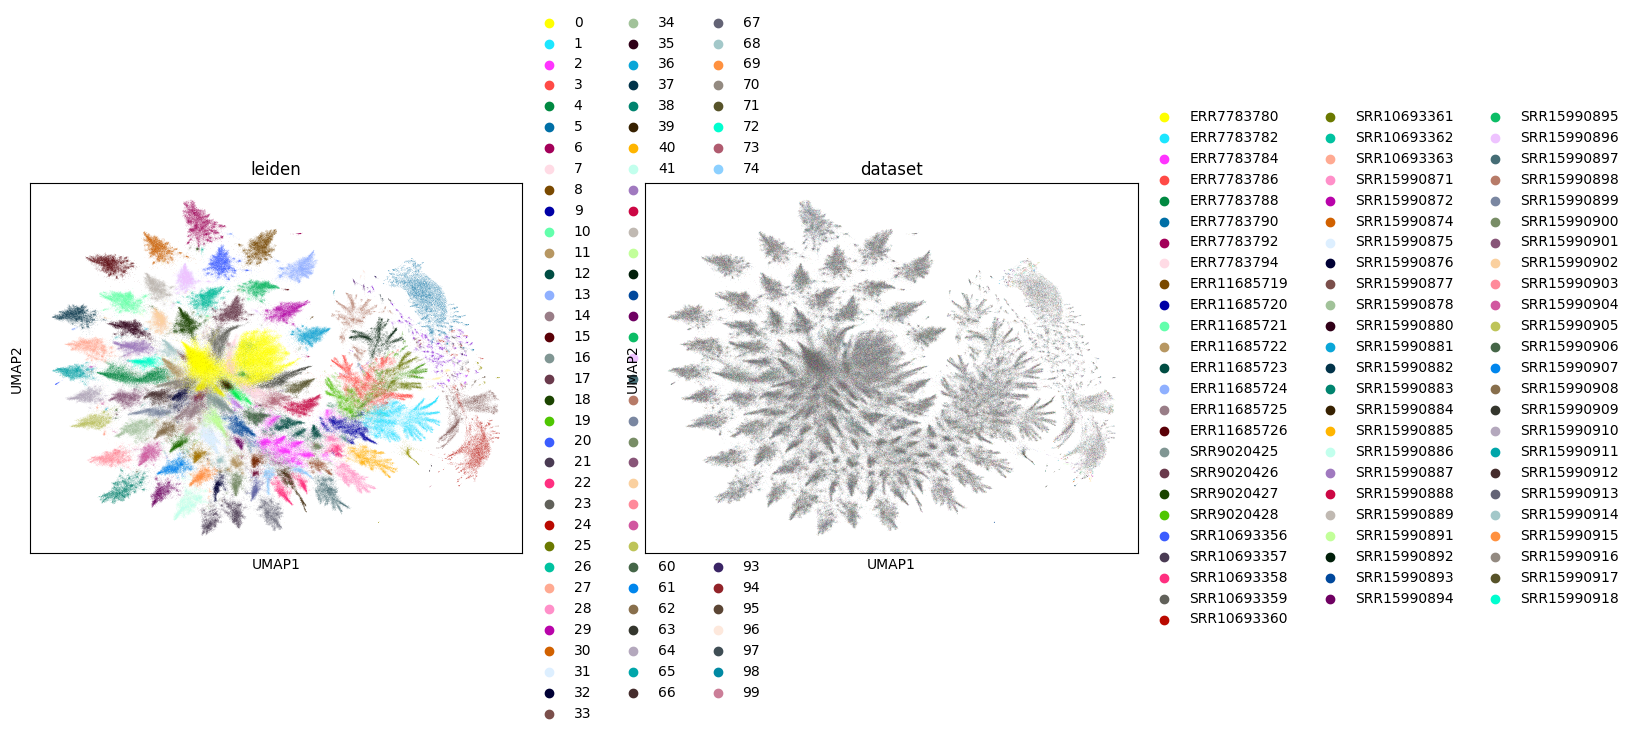

In [15]:
sc.pl.umap(adata, color=['leiden', 'dataset'])

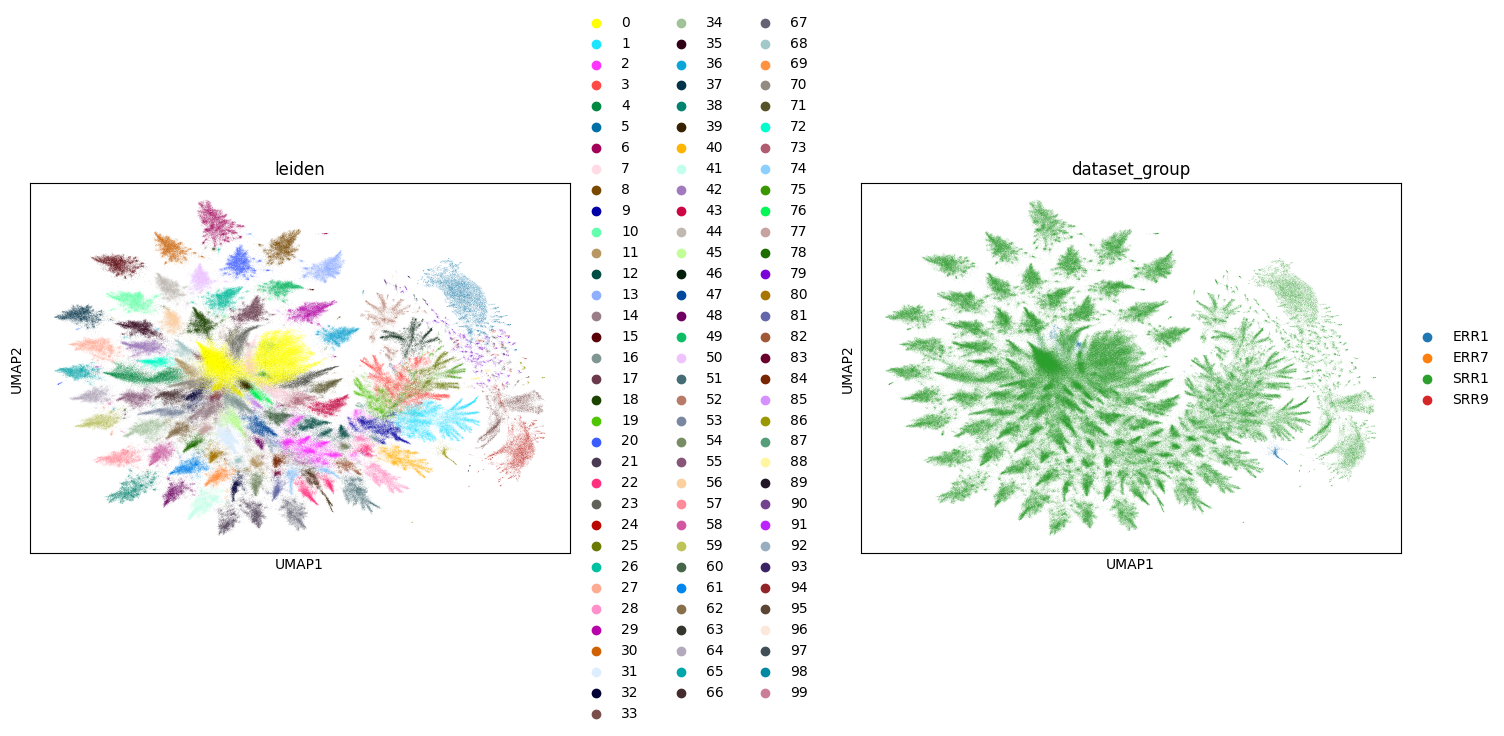

In [21]:
# Создаем столбец с группировкой по первым 4 символам
adata.obs['dataset_group'] = adata.obs['dataset'].astype(str).str[:4]

# Визуализация сгруппированных данных
sc.pl.umap(adata, color=['leiden', 'dataset_group'], wspace=0.4)

/tmp/ipykernel_2822952/3333328586.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_2822952/3333328586.py:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2822952/3333328586.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"umap_{sample_id}_highlighted.png", dpi=300)
/nfs/home/aneurov/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


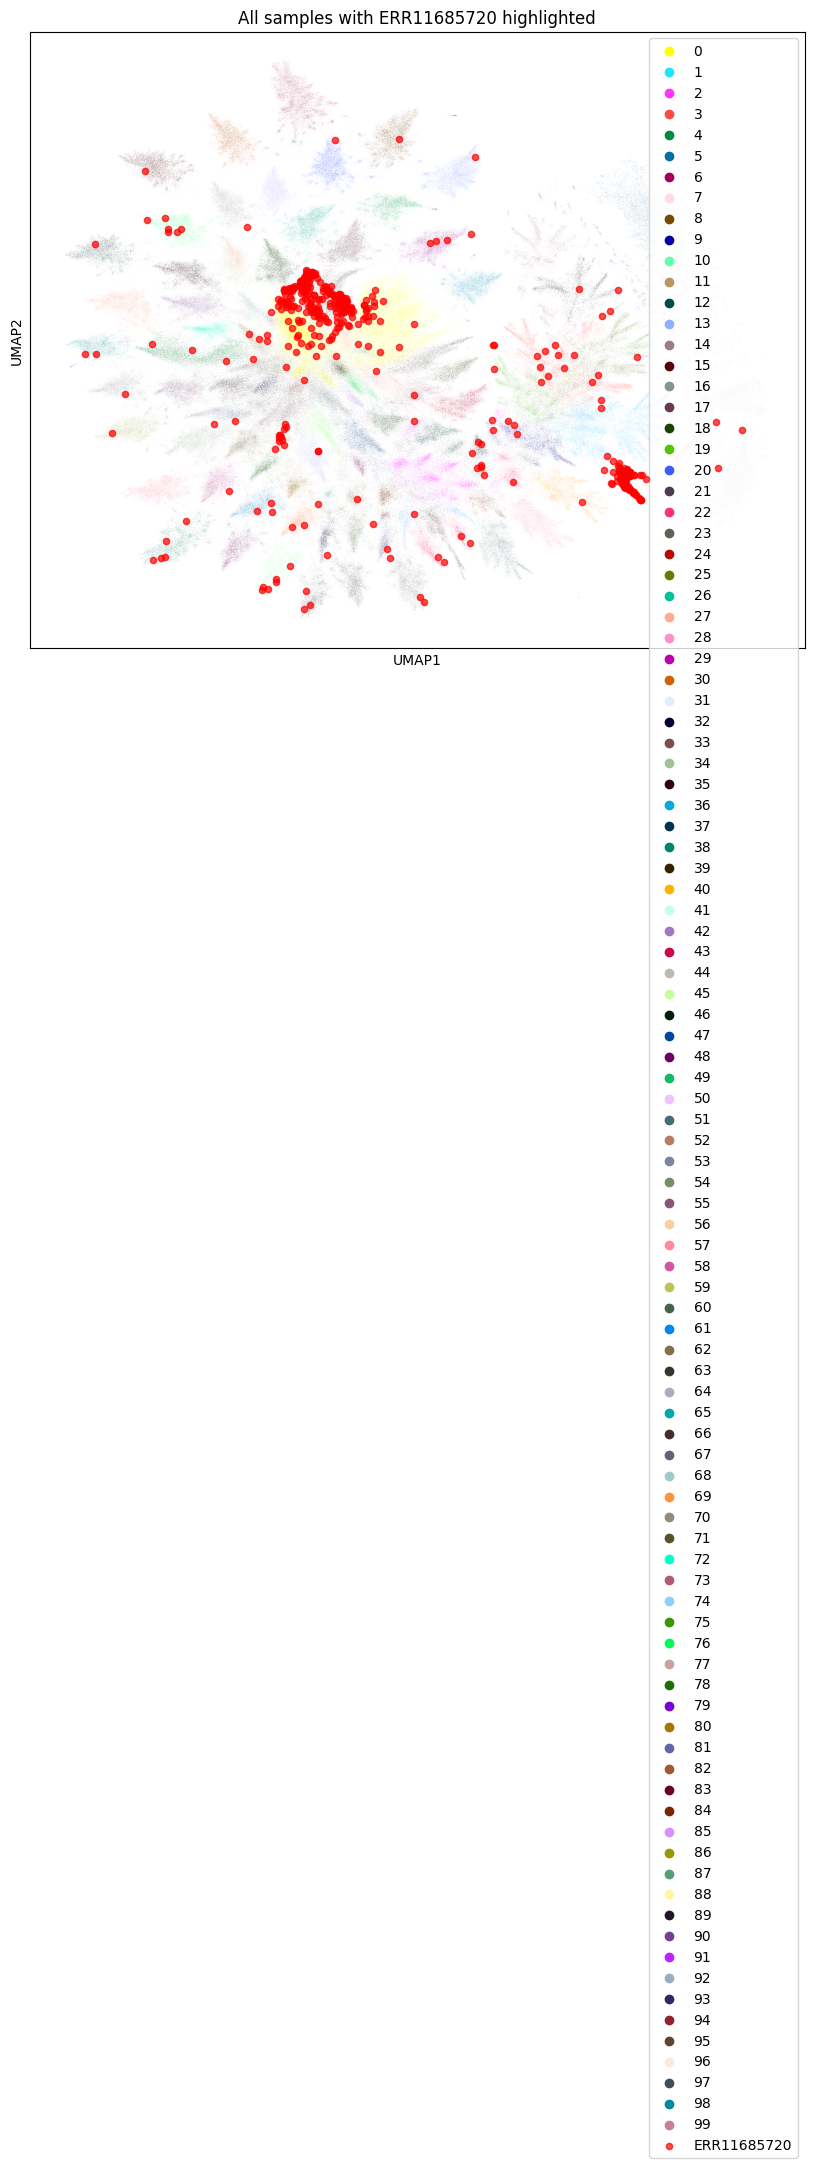

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Создаем столбец с флагом для интересующего образца
sample_id = "ERR11685720"
adata.obs['highlight'] = adata.obs['dataset'] == sample_id

# Получаем булев массив для фильтрации
highlight_mask = adata.obs['highlight'].values

# Получаем координаты UMAP
umap_coords = adata.obsm['X_umap']

# Строим базовый UMAP для всех клеток
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(
    adata, 
    color='leiden', 
    show=False, 
    title=f"All samples with {sample_id} highlighted",
    ax=ax,
    alpha=0.3  # Прозрачность для фона
)

# Подсвечиваем клетки нужного образца поверх основного графика
plt.scatter(
    umap_coords[highlight_mask, 0],  # X координаты
    umap_coords[highlight_mask, 1],  # Y координаты
    s=20,                            # Размер точек
    c='red',                         # Цвет
    alpha=0.7,                       # Прозрачность
    label=sample_id,                 # Метка для легенды
    zorder=10                        # Рисовать поверх других элементов
)

# Добавляем легенду
plt.legend()

# Сохраняем и показываем результат
plt.tight_layout()
plt.savefig(f"umap_{sample_id}_highlighted.png", dpi=300)
plt.show()

In [26]:
import scanpy as sc

# Подбираем разрешение для получения ~20 кластеров
target_clusters = 20
current_clusters = len(adata.obs['leiden'].cat.categories)
current_res = adata.uns['leiden']['params']['resolution']

# Рассчитываем новое разрешение
new_res = current_res * (target_clusters / current_clusters)
print(f"Текущее разрешение: {current_res:.3f} -> Новое разрешение: {new_res:.3f}")

# Пересчитываем кластеризацию
sc.tl.leiden(adata, resolution=new_res, key_added='leiden_lowres')

# Проверяем количество кластеров
n_clusters = len(adata.obs['leiden_lowres'].cat.categories)
print(f"Получено кластеров: {n_clusters}")

Текущее разрешение: 0.500 -> Новое разрешение: 0.100
Получено кластеров: 28


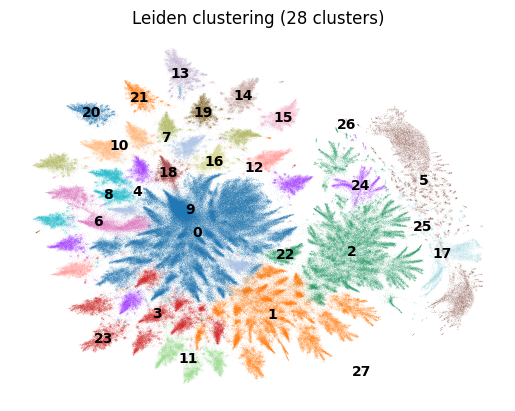

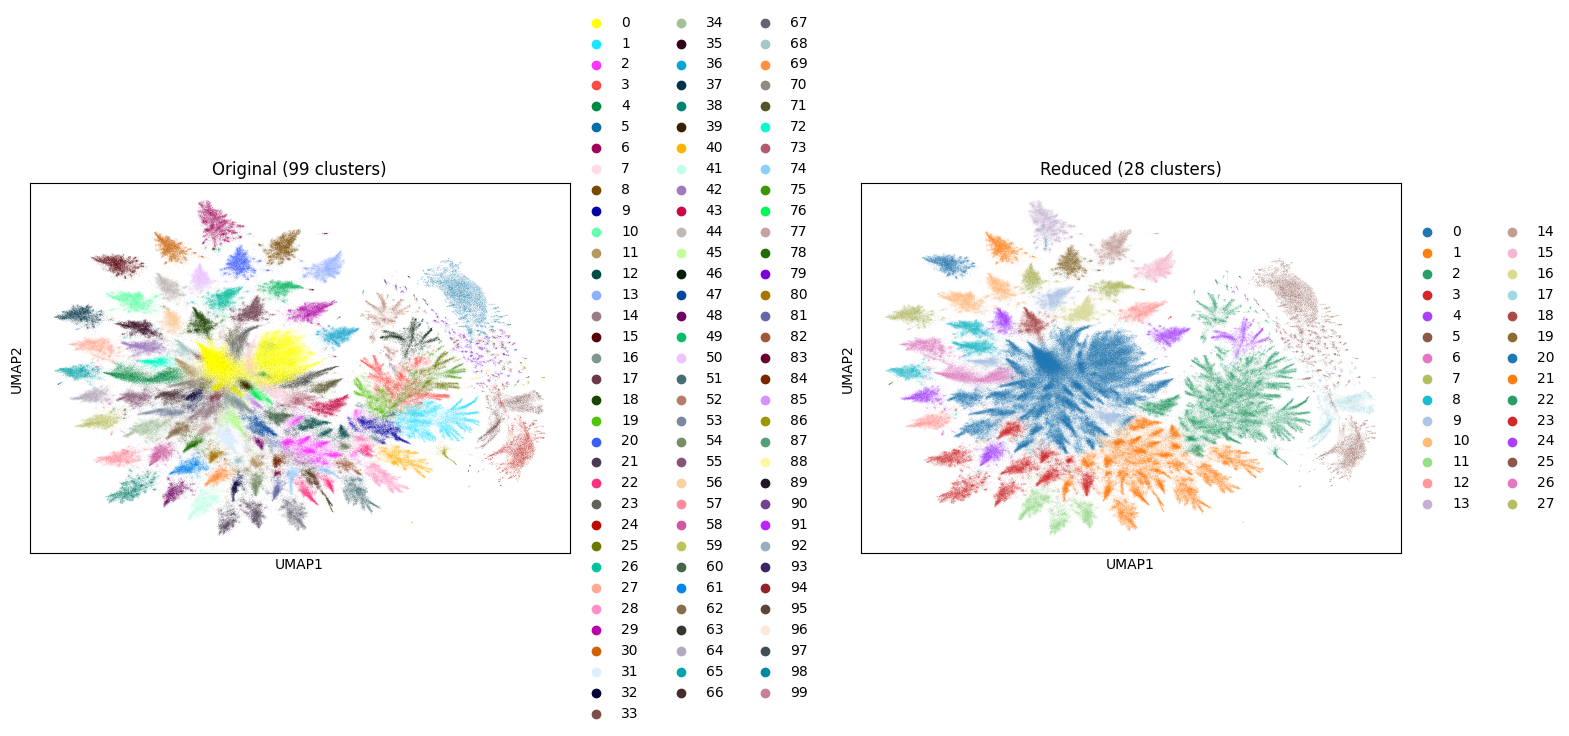

In [27]:
# Визуализация новой кластеризации
sc.pl.umap(
    adata,
    color='leiden_lowres',
    legend_loc='on data',
    title=f'Leiden clustering ({n_clusters} clusters)',
    frameon=False,
    palette=sc.pl.palettes.default_20,  # Используем палитру для 20 цветов
    save='_lowres_clusters.png'
)

# Сравнение со старой кластеризацией
sc.pl.umap(
    adata,
    color=['leiden', 'leiden_lowres'],
    wspace=0.4,
    ncols=2,
    title=['Original (99 clusters)', f'Reduced ({n_clusters} clusters)'],
    save='_cluster_comparison.png'
)

In [29]:
# Сохранение результатов
adata.write('adata_with_lowres_clusters.h5ad')
print("Данные сохранены с новой кластеризацией")

Данные сохранены с новой кластеризацией


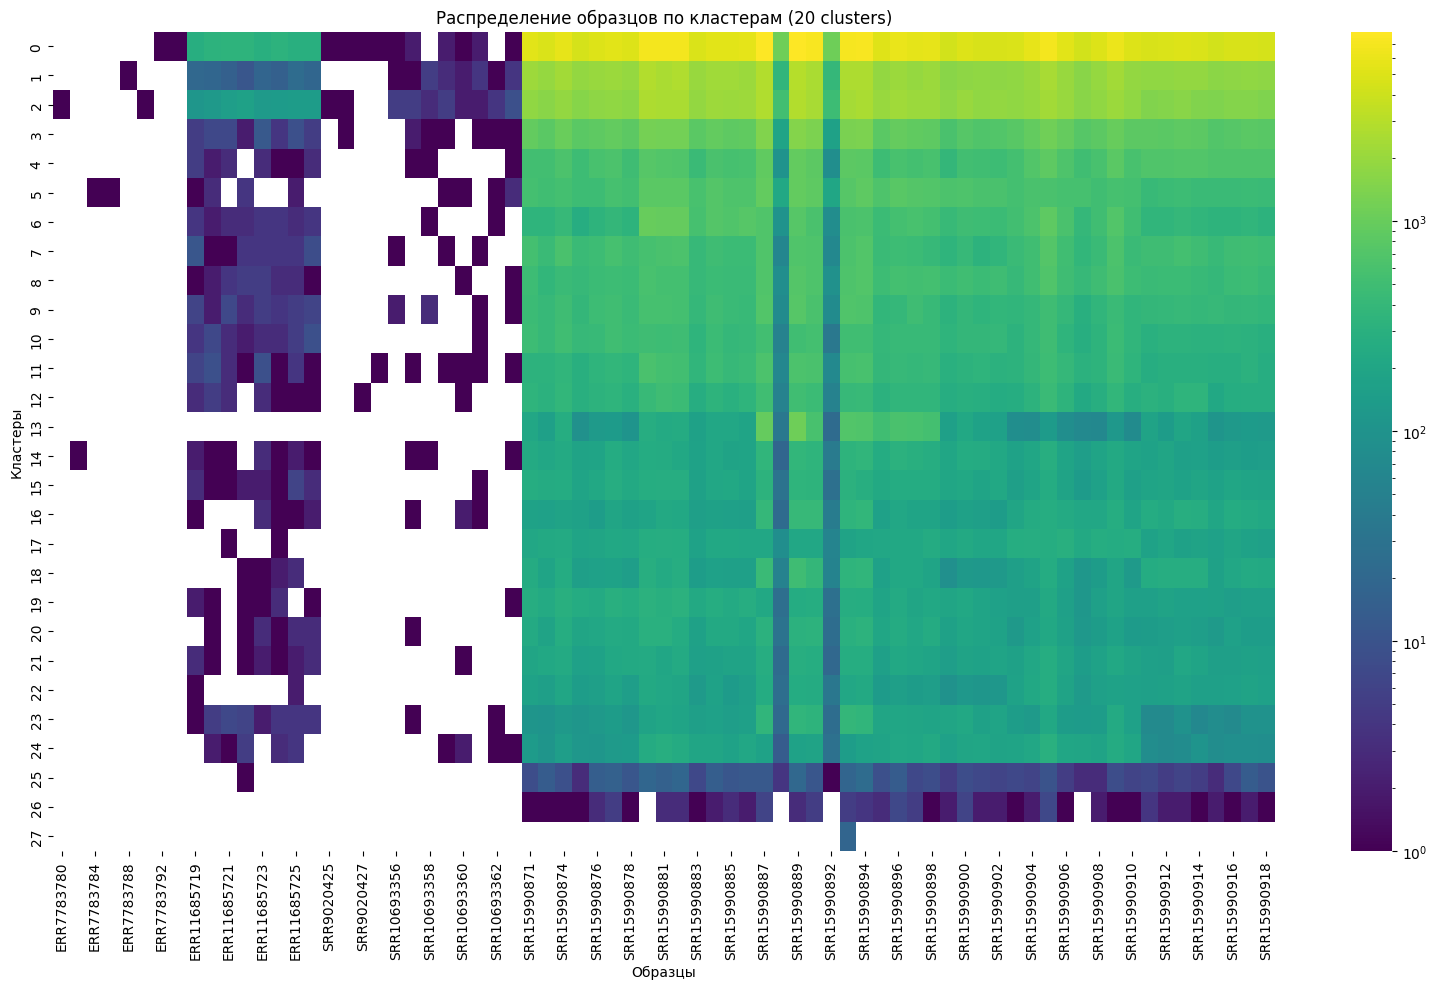

In [34]:
# Создаем кросс-таблицу
cluster_sample_table = pd.crosstab(
    adata.obs['leiden_lowres'],
    adata.obs['dataset']
)

# Визуализация
plt.figure(figsize=(16, 10))
sns.heatmap(
    cluster_sample_table,
    cmap="viridis",
    norm=LogNorm(vmin=1, vmax=cluster_sample_table.max().max())
)
plt.title("Распределение образцов по кластерам (20 clusters)")
plt.xlabel("Образцы")
plt.ylabel("Кластеры")
plt.tight_layout()
plt.savefig("cluster_sample_heatmap_lowres.png", dpi=300)

Найдено генов: 18/22
Отсутствующие гены:
1. (Mir9883)
2. (LOC100577092)
3. (EF1a-F2)
4. (LOC409634)
UMAP визуализация сохранена в target_genes_umap.png
Violin plot сохранен в target_genes_violin.png


TypeError: Image data of dtype object cannot be converted to float

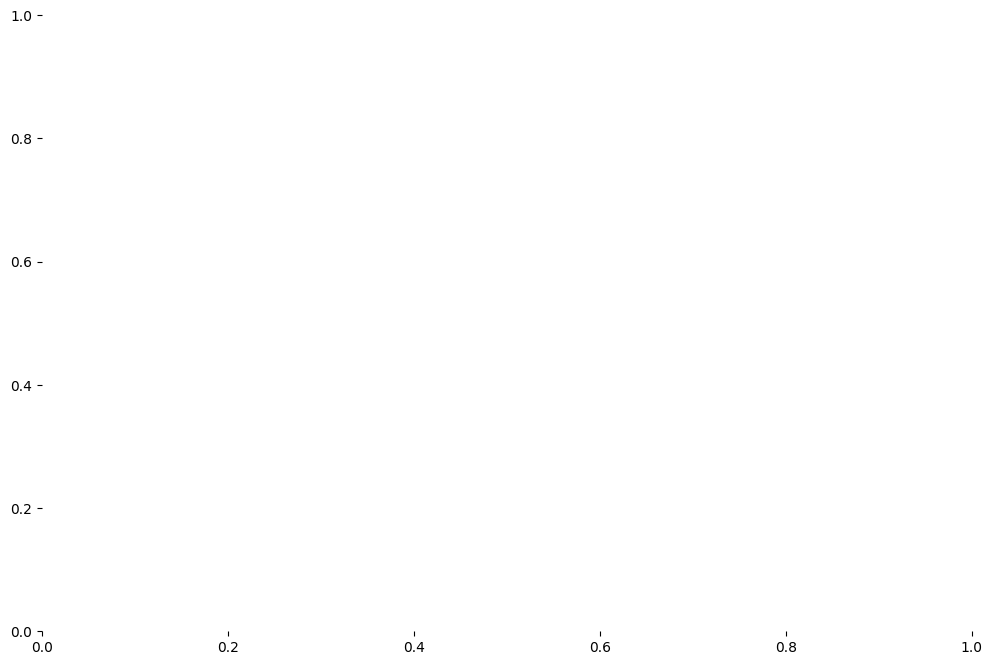

In [39]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Список целевых генов
target_genes = [
    '(LOC102656354)', '(Tsf1)', '(LOC102653599)', '(LOC408695)', '(LOC408696)',
    '(LOC409077)', '(LOC725960)', '(LOC552326)', '(LOC552734)', '(Mir6054)',
    '(Mir9883)', '(LOC100577092)', '(LOC413324)', '(LOC408452)', '(LOC724211)',
    '(LOC726472)', '(LOC409791)', '(Fabp)', '(LOC726321)', '(EF1a-F2)',
    '(LOC410467)', '(LOC409634)'
]

# Проверка наличия генов в данных
valid_genes = [gene for gene in target_genes if gene in adata.var_names]
missing_genes = [gene for gene in target_genes if gene not in adata.var_names]

print(f"Найдено генов: {len(valid_genes)}/{len(target_genes)}")
if missing_genes:
    print("Отсутствующие гены:")
    for i, gene in enumerate(missing_genes, 1):
        print(f"{i}. {gene}")
else:
    print("Все гены найдены!")

# Если найдены гены, выполняем визуализацию
if valid_genes:
    # Настройка размеров графиков
    n_genes = len(valid_genes)
    ncols = 3
    nrows = int(np.ceil(n_genes / ncols))
    
    # Создаем фигуру для UMAP
    fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
    axs = axs.flatten() if n_genes > 1 else [axs]
    
    # Рисуем экспрессию для каждого гена
    for i, gene in enumerate(valid_genes):
        sc.pl.umap(
            adata,
            color=gene,
            ax=axs[i],
            show=False,
            cmap='viridis',
            size=20 if adata.n_obs < 50000 else 5,
            vmax='p99.9',  # Используем 99.9 перцентиль для масштабирования
            title=gene,
            frameon=False
        )
    
    # Удаляем лишние оси
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.savefig("target_genes_umap.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("UMAP визуализация сохранена в target_genes_umap.png")
    
    # Анализ экспрессии по кластерам
    cluster_key = 'leiden_20' if 'leiden_20' in adata.obs else 'leiden'
    
    # Создаем stacked violin plot
    fig, ax = plt.subplots(figsize=(14, 10))
    sc.pl.stacked_violin(
        adata,
        var_names=valid_genes,
        groupby=cluster_key,
        ax=ax,
        swap_axes=True,
        show=False,
        title="Экспрессия целевых генов по кластерам"
    )
    
    plt.tight_layout()
    plt.savefig("target_genes_violin.png", dpi=300, bbox_inches='tight')
    plt.close()
    print("Violin plot сохранен в target_genes_violin.png")
    
    # Дополнительно: матрица средних экспрессий
    cluster_means = pd.DataFrame(index=adata.obs[cluster_key].cat.categories)
    
    for gene in valid_genes:
        # Вычисляем среднюю экспрессию в каждом кластере
        mean_expr = []
        for cluster in cluster_means.index:
            mask = adata.obs[cluster_key] == cluster
            expr = adata[mask, gene].X.mean()
            mean_expr.append(expr)
        
        cluster_means[gene] = mean_expr
    
    # Визуализация тепловой карты
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        cluster_means.T,
        cmap='viridis',
        robust=True,  # Игнорирует выбросы
        xticklabels=True,
        yticklabels=True,
        cbar_kws={'label': 'Средняя экспрессия'}
    )
    plt.title("Средняя экспрессия генов по кластерам")
    plt.xlabel("Кластеры")
    plt.ylabel("Гены")
    plt.tight_layout()
    plt.savefig("target_genes_heatmap.png", dpi=300)
    plt.close()
    print("Тепловая карта сохранена в target_genes_heatmap.png")
    
    # Сохраняем матрицу экспрессии
    cluster_means.to_csv("cluster_gene_expression.csv")
    print("Данные экспрессии сохранены в cluster_gene_expression.csv")
else:
    print("Нет валидных генов для визуализации.")

/tmp/ipykernel_2822952/1898378736.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1600x1000 with 0 Axes>

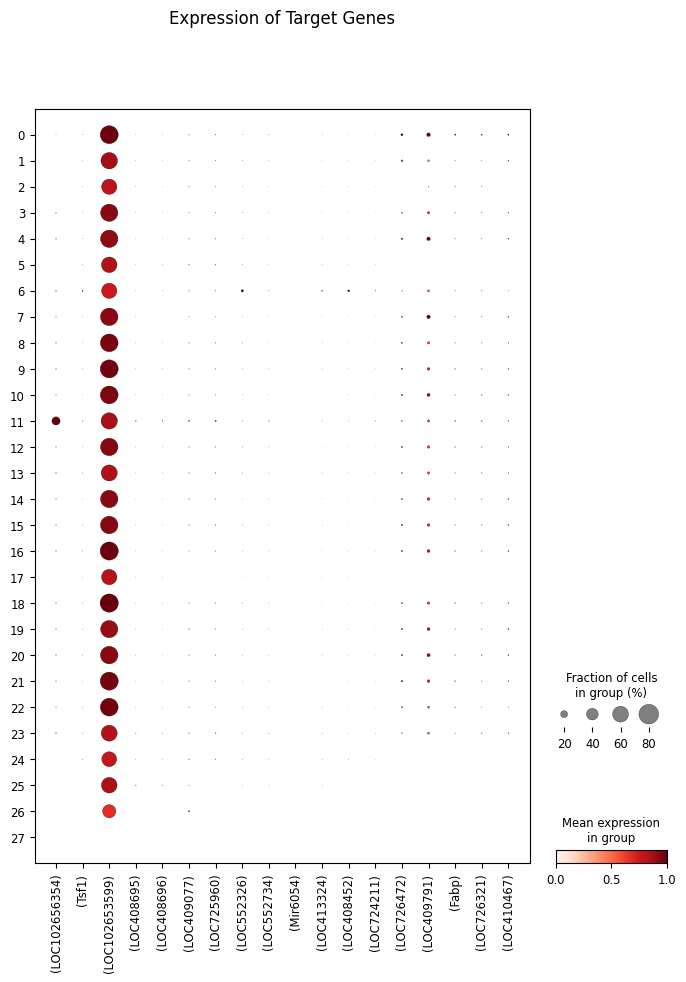

In [47]:
target_genes = [
    '(LOC102656354)', '(Tsf1)', '(LOC102653599)', '(LOC408695)', '(LOC408696)',
    '(LOC409077)', '(LOC725960)', '(LOC552326)', '(LOC552734)', '(Mir6054)',
    '(LOC413324)', '(LOC408452)', '(LOC724211)',
    '(LOC726472)', '(LOC409791)', '(Fabp)', '(LOC726321)', '(LOC410467)'
]

# Строим dotplot напрямую
plt.figure(figsize=(16, 10))
sc.pl.dotplot(
    adata,
    var_names=target_genes,
    groupby='leiden_lowres',
    title='Expression of Target Genes',
    swap_axes=False,  # Кластеры снизу, гены слева
    standard_scale='var',  # Масштабирование по генам
    show=False
)

# Настраиваем внешний вид
plt.yticks(rotation=0)  # Горизонтальные подписи для генов
plt.tight_layout()

# Сохраняем и показываем
plt.savefig("target_genes_dotplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
# Проверка позиции в общем рейтинге
gene_ranks = adata.var['mean_counts'].rank(ascending=False)
for gene in target_genes:
    if gene in gene_ranks.index:
        rank = gene_ranks[gene]
        total_genes = len(gene_ranks)
        print(f"Ген {gene}: позиция {rank:.0f}/{total_genes} (топ {100*rank/total_genes:.1f}%)")

# Визуализация экспрессии
sc.pl.umap(
    adata,
    color=target_genes,
    ncols=4,
    cmap='viridis',
    size=20,
    frameon=False,
    vmax='p99.9',
    show=False,
    save='_target_genes_expression.png'
)

Ген (LOC102656354): позиция 129/3000 (топ 4.3%)
Ген (Tsf1): позиция 2851/3000 (топ 95.0%)
Ген (LOC102653599): позиция 7/3000 (топ 0.2%)
Ген (LOC408695): позиция 2999/3000 (топ 100.0%)
Ген (LOC408696): позиция 2985/3000 (топ 99.5%)
Ген (LOC409077): позиция 1318/3000 (топ 43.9%)
Ген (LOC725960): позиция 1194/3000 (топ 39.8%)
Ген (LOC552326): позиция 2019/3000 (топ 67.3%)
Ген (LOC552734): позиция 2914/3000 (топ 97.1%)
Ген (Mir6054): позиция 210/3000 (топ 7.0%)
Ген (LOC413324): позиция 2942/3000 (топ 98.1%)
Ген (LOC408452): позиция 3000/3000 (топ 100.0%)
Ген (LOC724211): позиция 2181/3000 (топ 72.7%)
Ген (LOC726472): позиция 32/3000 (топ 1.1%)
Ген (LOC409791): позиция 17/3000 (топ 0.6%)
Ген (Fabp): позиция 694/3000 (топ 23.1%)
Ген (LOC726321): позиция 940/3000 (топ 31.3%)
Ген (LOC410467): позиция 125/3000 (топ 4.2%)


[<Axes: title={'center': '(LOC102656354)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(Tsf1)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC102653599)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC408695)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC408696)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC409077)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC725960)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC552326)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC552734)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(Mir6054)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC413324)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC408452)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC724211)'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': '(LOC726472)'}


Топ-20 наиболее экспрессируемых генов:
          Gene  Average Expression
(LOC107964104)        2.452244e-13
       (Rps14)        2.339230e-13
   (LOC551107)        2.337628e-13
(LOC113218601)        2.141264e-13
      (Ancr-1)        2.114680e-13
   (LOC724592)        2.004047e-13
(LOC102653599)        1.914940e-13
   (LOC409232)        1.262356e-13
   (LOC410637)        1.070532e-13
   (LOC408799)        1.010417e-13
         (Ant)        9.673620e-14
   (LOC725147)        9.377937e-14
   (LOC725383)        8.871665e-14
   (LOC551774)        8.604172e-14
(LOC100576540)        7.803843e-14
      (Uqcr11)        7.747545e-14
   (LOC409791)        7.558004e-14
   (LOC410353)        6.525821e-14
   (LOC551859)        6.484244e-14
      (ATP5G2)        6.301840e-14


/nfs/home/aneurov/.local/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


<Figure size 1200x800 with 0 Axes>

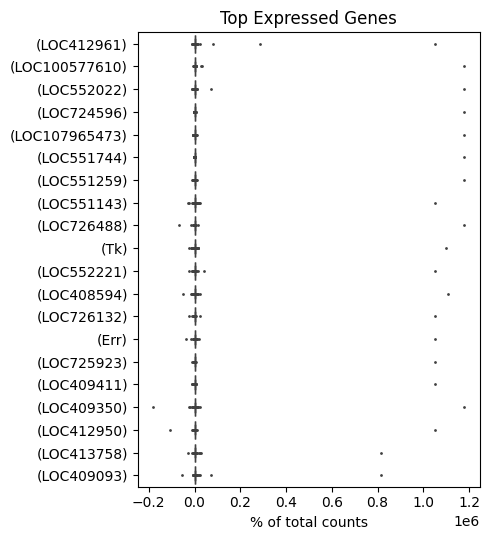

In [48]:
# 1. Вычисление среднего количества молекул на ген
sc.pp.calculate_qc_metrics(
    adata, 
    percent_top=None, 
    log1p=False, 
    inplace=True
)

# 2. Топ-20 наиболее экспрессируемых генов
top_genes = adata.var.sort_values('mean_counts', ascending=False).head(20)

# Создаем красивую таблицу для отображения
top_genes_table = top_genes[['mean_counts']].copy()
top_genes_table['gene'] = top_genes_table.index
top_genes_table = top_genes_table[['gene', 'mean_counts']]

# Переименовываем колонки для ясности
top_genes_table.columns = ['Gene', 'Average Expression']

# Выводим таблицу
print("\nТоп-20 наиболее экспрессируемых генов:")
print(top_genes_table.to_string(index=False))

# 3. Визуализация топ экспрессируемых генов
plt.figure(figsize=(12, 8))
sc.pl.highest_expr_genes(
    adata, 
    n_top=20,
    show=False
)
plt.title('Top Expressed Genes')
plt.tight_layout()
plt.savefig("top_expressed_genes.png", dpi=300)
plt.show()

In [49]:
# Поиск маркерных генов для кластеров
sc.tl.rank_genes_groups(
    adata, 
    groupby='leiden_lowres',
    method='wilcoxon',  # Оптимально для scRNA-seq
    key_added='rank_genes_clusters',
    pts=True  # Сохраняем долю клеток, экспрессирующих ген
)

/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/

In [51]:
# Визуализация топ маркерных генов
sc.pl.rank_genes_groups_dotplot(
    adata,
    groupby='leiden_lowres',
    n_genes=5,
    key='rank_genes_clusters',
    show=False,
    save='_markers.png'
)

{'mainplot_ax': <Axes: >,
 'group_extra_ax': <Axes: >,
 'gene_group_ax': <Axes: >,
 'size_legend_ax': <Axes: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <Axes: title={'center': 'Mean expression\nin group'}>}

In [52]:
markers_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_clusters')
markers_df.to_csv("cluster_markers.csv", index=False)

In [6]:
# Вычисляем маркерные гены, если еще не сделано
if 'rank_genes_clusters' not in adata.uns:
    print("Вычисляем маркерные гены для кластеризации 'leiden_lowres'...")
    sc.tl.rank_genes_groups(
        adata, 
        groupby='leiden_lowres',
        method='wilcoxon',  # Метод по умолчанию
        key_added='rank_genes_clusters',
        n_genes=50  # Сохраняем топ-50 генов для каждого кластера
    )

# Создаем heatmap для топ маркерных генов
plt.figure(figsize=(16, 12))  # Увеличиваем размер для читаемости

# Основная heatmap
sc.pl.rank_genes_groups_heatmap(
    adata,
    groupby='leiden_lowres',
    n_genes=5,  # Топ-5 генов для каждого кластера
    key='rank_genes_clusters',
    show_gene_labels=True,
    gene_symbols=None,  # Используем индексы генов из var_names
    vmin=-2,  # Минимальное значение для цветовой шкалы
    vmax=4,   # Максимальное значение для цветовой шкалы
    cmap='viridis',
    swap_axes=False,  # Кластеры по вертикали, гены по горизонтали
    show=False,
    dendrogram=True,  # Показывать дендрограмму кластеров
    use_raw=False,    # Использовать обработанные данные
    var_group_rotation=90,  # Вертикальные подписи генов
    figsize=(max(12, len(adata.obs['leiden_lowres'].cat.categories)*0.5), 10)
)

# Дополнительные настройки
plt.title('Top Marker Genes per Cluster', fontsize=16, pad=20)
plt.tight_layout()

# Сохраняем с высоким разрешением
plt.savefig("marker_genes_heatmap.png", dpi=300, bbox_inches='tight')
plt.savefig("marker_genes_heatmap.pdf", bbox_inches='tight')  # Векторный формат
plt.show()

print("Heatmap маркерных генов сохранена в marker_genes_heatmap.png и marker_genes_heatmap.pdf")


Вычисляем маркерные гены для кластеризации 'leiden_lowres'...


/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/aneurov/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/nfs/home/

NameError: name 'plt' is not defined

/tmp/ipykernel_2992805/1946215336.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1600x1200 with 0 Axes>

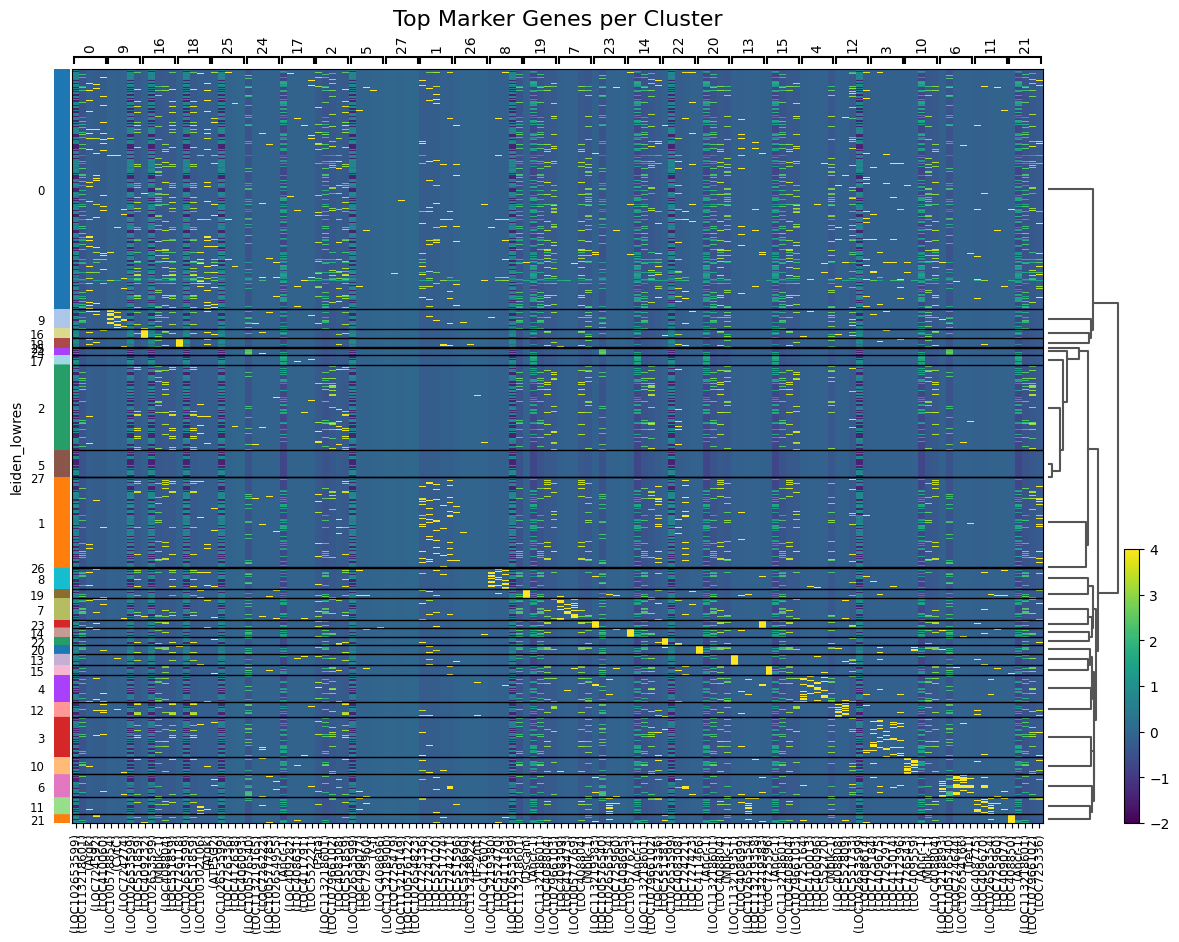

Heatmap маркерных генов сохранена в marker_genes_heatmap.png и marker_genes_heatmap.pdf


In [10]:
plt.figure(figsize=(16, 12))  # Увеличиваем размер для читаемости

# Основная heatmap
sc.pl.rank_genes_groups_heatmap(
    adata,
    groupby='leiden_lowres',
    n_genes=5,  # Топ-5 генов для каждого кластера
    key='rank_genes_clusters',
    show_gene_labels=True,
    gene_symbols=None,  # Используем индексы генов из var_names
    vmin=-2,  # Минимальное значение для цветовой шкалы
    vmax=4,   # Максимальное значение для цветовой шкалы
    cmap='viridis',
    swap_axes=False,  # Кластеры по вертикали, гены по горизонтали
    show=False,
    dendrogram=True,  # Показывать дендрограмму кластеров
    use_raw=False,    # Использовать обработанные данные
    var_group_rotation=90,  # Вертикальные подписи генов
    figsize=(max(12, len(adata.obs['leiden_lowres'].cat.categories)*0.5), 10)
)

# Дополнительные настройки
plt.title('Top Marker Genes per Cluster', fontsize=16, pad=20)
plt.tight_layout()

# Сохраняем с высоким разрешением
plt.savefig("marker_genes_heatmap.png", dpi=300, bbox_inches='tight')
plt.savefig("marker_genes_heatmap.pdf", bbox_inches='tight')  # Векторный формат
plt.show()

print("Heatmap маркерных генов сохранена в marker_genes_heatmap.png и marker_genes_heatmap.pdf")


In [9]:
import matplotlib.pyplot as plt

In [53]:
# Сначала получим DataFrame с маркерными генами
markers_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_clusters')

# Создадим словарь marker_dict
marker_dict = {}
for cluster in markers_df['group'].unique():
    # Выберем топ-5 генов для каждого кластера по scores
    top_genes = markers_df[markers_df['group'] == cluster].sort_values('scores', ascending=False).head(5)
    marker_dict[cluster] = top_genes['names'].tolist()

# Теперь создадим список всех топ-генов в порядке кластеров
all_top_genes = []
for cluster in sorted(marker_dict.keys()):
    all_top_genes.extend(marker_dict[cluster])

print("Все топ-гены:", all_top_genes)

# Выведем информацию по кластерам
print("\nТоп-5 маркерных генов для каждого кластера:")
for cluster, genes in marker_dict.items():
    print(f"Кластер {cluster}: {', '.join(genes)}")

Все топ-гены: ['(LOC102653599)', '(LOC113218601)', '(Argk)', '(LOC724592)', '(LOC410060)', '(LOC725336)', '(LOC724172)', '(LOC552020)', '(LOC551774)', '(LOC724221)', '(LOC726543)', '(LOC409559)', '(Ancr-1)', '(Mblk-1)', '(LOC408804)', '(LOC408775)', '(LOC409670)', '(LOC102656354)', '(LOC725960)', '(LOC409077)', '(LOC408808)', '(LOC552809)', '(LOC551733)', '(LOC102653599)', '(LOC408614)', '(LOC113219351)', '(LOC408699)', '(LOC102656354)', '(LOC113219358)', '(LOC113219383)', '(LOC100577623)', '(Ancr-1)', '(LOC113218601)', '(LOC107966102)', '(LOC725336)', '(LOC725596)', '(Ancr-1)', '(LOC113218601)', '(LOC408804)', '(LOC107966103)', '(LOC409232)', '(LOC102653599)', '(Mblk-1)', '(LOC408804)', '(LOC551859)', '(Ancr-1)', '(LOC409282)', '(LOC408631)', '(LOC411791)', '(LOC552221)', '(LOC726118)', '(LOC102653599)', '(LOC551859)', '(LOC100302106)', '(Argk)', '(Dscam)', '(Ancr-1)', '(LOC113218601)', '(LOC408804)', '(LOC107966103)', '(Para)', '(LOC113218601)', '(LOC107966102)', '(LOC408308)', '(LOC

/tmp/ipykernel_2822952/1898378736.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1600x1000 with 0 Axes>

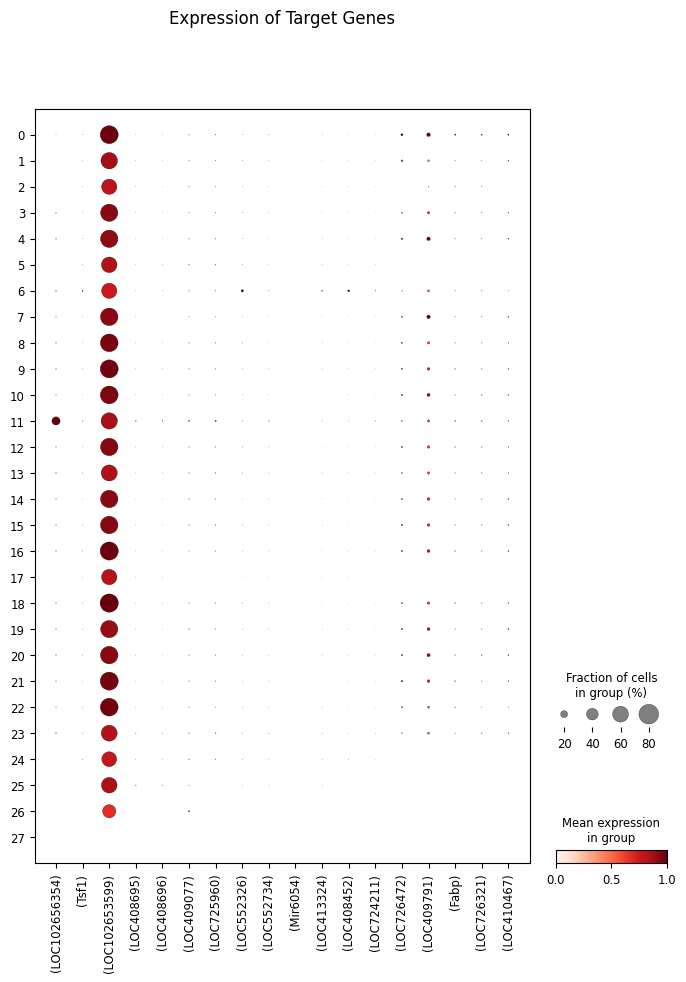

In [ ]:
target_genes = [
    '(LOC102656354)', '(Tsf1)', '(LOC102653599)', '(LOC408695)', '(LOC408696)',
    '(LOC409077)', '(LOC725960)', '(LOC552326)', '(LOC552734)', '(Mir6054)',
    '(LOC413324)', '(LOC408452)', '(LOC724211)',
    '(LOC726472)', '(LOC409791)', '(Fabp)', '(LOC726321)', '(LOC410467)'
]

# Строим dotplot напрямую
plt.figure(figsize=(16, 10))
sc.pl.dotplot(
    adata,
    var_names=target_genes,
    groupby='leiden_lowres',
    title='Expression of Target Genes',
    swap_axes=False,  # Кластеры снизу, гены слева
    standard_scale='var',  # Масштабирование по генам
    show=False
)

# Настраиваем внешний вид
plt.yticks(rotation=0)  # Горизонтальные подписи для генов
plt.tight_layout()

# Сохраняем и показываем
plt.savefig("target_genes_dotplot.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Создаем словарь для аннотации кластеров
cluster_annotations = {
    '0': 'Neurons (general)',
    '1': 'Mushroom Body Neurons',
    '2': 'Excitatory Neurons',
    '3': 'Mitochondrial-rich Cells',
    '4': 'Kenyon Cells Subtype 1',
    '5': 'Glial Cells',
    '6': 'Ependymal-like Cells',
    '7': 'Kenyon Cells Subtype 2',
    '8': 'Astrocyte-like Glia',
    '9': 'Calcium-binding Neurons',
    '10': 'Kenyon Cells Subtype 3',
    '11': 'Olfactory Neurons',
    '12': 'Neuroendocrine Cells',
    '13': 'Progenitor Cells',
    '14': 'Mushroom Body Neurons Subtype',
    '15': 'Immune-like Cells',
    '16': 'Mixed Neuronal-Glial',
    '17': 'Developing Neurons',
    '18': 'Photoreceptor-associated',
    '19': 'Immature Neurons',
    '20': 'Kenyon Cells Subtype 4',
    '21': 'Mushroom Body Neurons Subtype',
    '22': 'High-metabolic Cells',
    '23': 'Proliferating Cells',
    '24': 'Mitochondrial Cells',
    '25': 'Contamination (Salivary)',
    '26': 'Ubiquitin-proteasome Cells',
    '27': 'Ciliated Cells'
}

# Добавляем аннотации в AnnData
adata.obs['cell_type'] = adata.obs['leiden_lowres'].astype(str).map(cluster_annotations)
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Unknown')

# Увеличиваем размер фигуры для лучшего отображения легенды
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

# Визуализация с легендой справа
sc.pl.umap(
    adata, 
    color='cell_type',
    legend_loc='right margin',  # Легенда на правой стороне
    legend_fontsize=8,         # Размер шрифта в легенде
    legend_fontoutline=2,      # Обводка текста для лучшей читаемости
    palette='tab20', 
    frameon=False,
    title='Annotated Cell Types',
    size=15,                   # Размер точек
    save='_cell_types_legend.png'
)

# Альтернативный вариант: легенда под графиком
sc.pl.umap(
    adata, 
    color='cell_type',
    legend_loc='on data',       # Убираем подписи на графике
    legend_fontsize=0,          # Скрываем текст на графике
    palette='tab20', 
    frameon=False,
    title='Annotated Cell Types',
    size=15,
    add_outline=True,           # Обводка кластеров для лучшего различения
    save='_cell_types_no_labels.png'
)

# Создаем отдельную легенду для сохранения
import matplotlib.patches as mpatches
patches = []
for i, ct in enumerate(adata.obs['cell_type'].cat.categories):
    patches.append(mpatches.Patch(color=sc.pl.palettes.default_20[i], label=ct))
    
plt.figure(figsize=(8, 10))
plt.axis('off')
plt.legend(handles=patches, loc='center', prop={'size': 8})
plt.tight_layout()
plt.savefig('cell_type_legend.png', dpi=300)
plt.close()

# Сохраняем аннотированные данные
adata.write('annotated_data.h5ad')

In [ ]:
caste_mapping = {
    # Pupae
    'ERR7783780': 'pupa',
    'ERR7783782': 'pupa',
    'ERR7783784': 'pupa',
    'ERR7783786': 'pupa',
    'ERR7783788': 'pupa',
    'ERR7783790': 'pupa',
    'ERR7783792': 'pupa',
    'ERR7783794': 'pupa',
    'ERR11685719': 'pupa',
    'ERR11685720': 'pupa',
    'ERR11685721': 'pupa',
    'ERR11685722': 'pupa',
    'ERR11685723': 'pupa',
    'ERR11685724': 'pupa',
    'ERR11685725': 'pupa',
    'ERR11685726': 'pupa',
    
    # Foragers
    'SRR10693356': 'forager',
    'SRR10693357': 'forager',
    'SRR10693358': 'forager',
    'SRR10693359': 'forager',
    'SRR10693360': 'forager',
    'SRR10693361': 'forager',
    'SRR10693362': 'forager',
    'SRR10693363': 'forager',
    'SRR15990871': 'forager',
    'SRR15990872': 'forager',
    'SRR15990873': 'forager',
    'SRR15990874': 'forager',
    'SRR15990875': 'forager',
    'SRR15990876': 'forager',
    'SRR15990877': 'forager',
    'SRR15990878': 'forager',
    'SRR15990879': 'forager',
    'SRR15990880': 'forager',
    'SRR15990881': 'forager',
    'SRR15990882': 'forager',
    'SRR15990883': 'forager',
    'SRR15990884': 'forager',
    'SRR15990885': 'forager',
    'SRR15990886': 'forager',
    
    # Nurses
    'SRR15990887': 'nurse',
    'SRR15990888': 'nurse',
    'SRR15990889': 'nurse',
    'SRR15990890': 'nurse',
    'SRR15990891': 'nurse',
    'SRR15990892': 'nurse',
    'SRR15990893': 'nurse',
    'SRR15990894': 'nurse',
    'SRR15990895': 'nurse',
    'SRR15990896': 'nurse',
    'SRR15990897': 'nurse',
    'SRR15990898': 'nurse',
    'SRR15990899': 'nurse',
    'SRR15990900': 'nurse',
    'SRR15990901': 'nurse',
    'SRR15990902': 'nurse',
    
    # Queens
    'SRR15990903': 'queen',
    'SRR15990904': 'queen',
    'SRR15990905': 'queen',
    'SRR15990906': 'queen',
    'SRR15990907': 'queen',
    'SRR15990908': 'queen',
    'SRR15990909': 'queen',
    'SRR15990910': 'queen',
    'SRR15990911': 'queen',
    'SRR15990912': 'queen',
    'SRR15990913': 'queen',
    'SRR15990914': 'queen',
    'SRR15990915': 'queen',
    'SRR15990916': 'queen',
    'SRR15990917': 'queen',
    'SRR15990918': 'queen'
}

# Добавляем информацию о касте в AnnData
adata.obs['caste'] = adata.obs['dataset'].map(caste_mapping)

# Проверяем
print("Распределение по кастам:")
print(adata.obs['caste'].value_counts())

In [ ]:
os.makedirs("markers", exist_ok=True)

def safe_de_analysis(adata, cell_type):
    """Безопасный DE анализ для типа клеток"""
    print(f"\nАнализ для: {cell_type}")
    
    # Фильтрация по типу клеток
    adata_sub = adata[adata.obs['cell_type'] == cell_type].copy()
    
    # Проверка количества клеток
    if adata_sub.n_obs < 10:
        print(f"  Пропуск: недостаточно клеток ({adata_sub.n_obs})")
        return None
    
    # Проверка количества каст
    caste_counts = adata_sub.obs['caste'].value_counts()
    valid_castes = caste_counts[caste_counts >= 3].index.tolist()
    
    if len(valid_castes) < 2:
        print(f"  Пропуск: недостаточно каст ({len(valid_castes)} с ≥3 клетками)")
        return None
    
    # Выполнение DE анализа
    cell_type_markers = {}
    for caste in valid_castes:
        try:
            # Получаем DE результаты для касты
            de_df = sc.get.rank_genes_groups_df(
                adata, 
                group=caste,
                key='rank_genes_groups_caste'
            )
            
            # Фильтрация по значимости и FC
            de_df = de_df[
                (de_df['pvals_adj'] < 0.05) & 
                (de_df['logfoldchanges'].abs() > 0.5)
            ].sort_values('scores', ascending=False)
            
            # Отбираем только гены, присутствующие в поднаборе
            valid_genes = [g for g in de_df['names'] if g in adata_sub.var_names]
            de_df = de_df[de_df['names'].isin(valid_genes)]
            
            # Рассчитываем среднюю экспрессию вручную
            expr_values = []
            for gene in de_df['names']:
                if gene in adata_sub.var_names:
                    # Для разреженных матриц
                    if scipy.sparse.issparse(adata_sub.X):
                        expr = adata_sub[:, gene].X.mean()
                    else:
                        expr = np.mean(adata_sub[:, gene].X)
                    expr_values.append(expr)
                else:
                    expr_values.append(0)
            
            de_df['expr_in_cell_type'] = expr_values
            de_df = de_df[de_df['expr_in_cell_type'] > 0].head(20)
            
            if not de_df.empty:
                cell_type_markers[caste] = de_df
                de_df.to_csv(f"markers/{cell_type}_{caste}_markers.csv", index=False)
                print(f"  Найдено {len(de_df)} маркеров для {caste}")
        
        except Exception as e:
            print(f"  Ошибка для {caste}: {str(e)}")
    
    return cell_type_markers

# Выполняем DE анализ для каждого типа клеток
caste_markers = {}
for cell_type in adata.obs['cell_type'].unique():
    if pd.isna(cell_type):
        continue
        
    markers = safe_de_analysis(adata, cell_type)
    if markers:
        caste_markers[cell_type] = markers

print("\nАнализ дифференциальной экспрессии завершен!")

In [ ]:
# Папка с результатами
markers_dir = "markers"

# Список всех файлов с маркерами
marker_files = [f for f in os.listdir(markers_dir) if f.endswith('_markers.csv')]

# Создаем пустой DataFrame для всех результатов
all_markers = pd.DataFrame()

# Читаем и объединяем все файлы
for file in marker_files:
    # Извлекаем информацию из имени файла
    parts = file.replace('_markers.csv', '').split('_')
    caste = parts[-1]
    cell_type = '_'.join(parts[:-1])
    
    # Читаем файл
    df = pd.read_csv(os.path.join(markers_dir, file))
    
    # Добавляем информацию о типе клеток и касте
    df['cell_type'] = cell_type
    df['caste'] = caste
    
    # Объединяем с основным DataFrame
    all_markers = pd.concat([all_markers, df], ignore_index=True)

# Фильтруем только значимые гены
significant_markers = all_markers[
    (all_markers['pvals_adj'] < 0.05) & 
    (abs(all_markers['logfoldchanges']) > 0.5)
]

In [ ]:
# Топ-10 генов с наибольшим средним logFC
top_genes = significant_markers.groupby('names')['logfoldchanges'].mean().abs().sort_values(ascending=False).head(10)
print("Топ-10 генов с наибольшими изменениями экспрессии:")
print(top_genes)

# Количество уникальных маркерных генов по кастам
caste_marker_counts = significant_markers.groupby('caste')['names'].nunique()
print("\nКоличество уникальных маркерных генов по кастам:")
print(caste_marker_counts)

# Количество уникальных маркерных генов по типам клеток
celltype_marker_counts = significant_markers.groupby('cell_type')['names'].nunique()
print("\nКоличество уникальных маркерных генов по типам клеток:")
print(celltype_marker_counts.sort_values(ascending=False))

In [ ]:
# Настройки визуализации
plt.rcParams.update({'font.size': 12})
sns.set_style("whitegrid")

# 1. Распределение logFC по кастам
plt.figure(figsize=(10, 6))
sns.boxplot(x='caste', y='logfoldchanges', data=significant_markers)
plt.title('Распределение изменений экспрессии генов по кастам')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('caste_logfc_distribution.png', dpi=300)
plt.show()

# 2. Тепловая карта количества маркеров по типам клеток и кастам
heatmap_data = significant_markers.groupby(['cell_type', 'caste']).size().unstack(fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='viridis')
plt.title('Количество значимых маркеров по типам клеток и кастам')
plt.xlabel('Каста')
plt.ylabel('Тип клеток')
plt.tight_layout()
plt.savefig('marker_count_heatmap.png', dpi=300)
plt.show()

# 3. Топ гены для каждой касты
for caste in significant_markers['caste'].unique():
    caste_df = significant_markers[significant_markers['caste'] == caste]
    top_genes = caste_df.groupby('names')['logfoldchanges'].mean().abs().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    top_genes.sort_values().plot(kind='barh')
    plt.title(f'Топ-10 генов для касты {caste}')
    plt.xlabel('Средний |log2 FC|')
    plt.tight_layout()
    plt.savefig(f'top_genes_{caste}.png', dpi=300)
    plt.show()